# Notebook for computing CLVs of the Lorenz 63 system

In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

### Time Parameters

In [21]:
dt = 1.e-2 # Time step for numerical integration, this is also the interval TLE is solved over
transient = int(1.e4) # Number of transient steps
tA = 10000 # Controls convergence to the BLVs. We also sample FTLEs from 0 - tA + tB + tC
tB = 10000 # Steps where we want CLVs at
tC = 10000 # Controls convergence to CLVs
L = tA + tB + tC

## Solving and Plotting Lorenz 63

In [22]:
# L63 Definition

#Parameters
a = 10.0
b = 8/3
c = 28.0
p = [a, b, c]

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

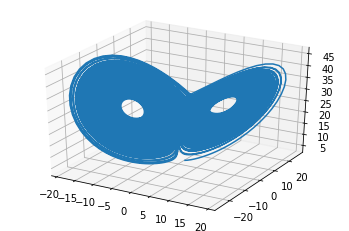

In [23]:
# Solving L63 Numerically using odeint

IC = np.array([1.0, 2.0, 3.0])
steps = transient + L # Where we're solving L63
time = np.arange(0, steps * dt, dt)
solution = odeint(L63, IC, time, (p,))

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
plt.show()

## Function for Jacobians

We will only need the jacobians after the transient period.

In [24]:
# Function to calucate Jacobian of L63 at a point on trajectory

def Jacobian(location, parameters):
    """Returns the jacobian matrix at a given point of L63.
    Param, location, array: [x, y, z] coordinates.
    Parameters, parameters, L63 parameters.
    """
    [a, b, c] = parameters
    [x, y, z] = location
    row1 = np.array([-a, a, 0])
    row2 = np.array([c - z, -1, -x])
    row3 = np.array([y, x, -b])
    J = np.array([row1, row2, row3])
    return J

# Test of Jacobian Function
# location = [2, 0, 1]
# print(Jacobian(location, [a, b, c]))

## Solving the Tangent Linear Equations

At each point along trajectory of L63 we define a TLE. We solve this numerically with Q_k as the IC. The solution our numerical integration gives is P_k = Q_k R_k. Never need the propagator!

#### First we define eveything we need for the TLEs

In [25]:
# RHS
def TLE(delta, time, p, state):
    """Defines RHS of the TLE at a given point on attractor.
    Param, delta, perturbation evolution being solved for.
    Param, time.
    Param, p, parameters of Lorenz system.
    Param, state, where we are on the attractor.
    """
    J = Jacobian(state, p)
    f = np.dot(J, delta)
    return f

# Time steps for TLE numerical integration
TLEtime = np.arange(0, dt, dt * 1.e-2) # Note tle is solved on interval [0, dt]

#### Function that solves TLE

In [26]:
def solveTLE(state, oldQ):
    """ Solves tangent linear equation.
    Param, state, array: where we are on the attractor, used to define TLE.
    Param, oldQ, IC of TLE being solved. 
    """
    TLEsolution0 = odeint(TLE, oldQ[:, 0], TLEtime, (p, state)) # Solving the TLE for different IC
    col1 = TLEsolution0[-1]
    TLEsolution1 = odeint(TLE, oldQ[:, 1], TLEtime, (p, state))
    col2 = TLEsolution1[-1]
    TLEsolution2 = odeint(TLE, oldQ[:, 2], TLEtime, (p, state))
    col3 = TLEsolution2[-1]
    Pk = np.column_stack((col1, col2, col3))
    return Pk

## Ginelli Algorithm for calculating the CLVs

In [27]:
lyap = np.zeros(3) # Running sum of FTLEs
lyapSum = np.zeros((L, 3)) # For storing time series of running sum

In [28]:
# Storage
Qs = np.zeros((3, 3, int(tB)))
print(Qs.shape)
Rs = Qs
Rs2 = np.zeros((3, 3, int(tC)))
CLVs = Qs

(3, 3, 10000)


### Step 1: Getting the BLVs & LEs via Benettin stepping. Ensure they converge

In [29]:
# Initialising an orthogonal matrix
eps = 1.e-6
oldQ = eps * np.identity(3)

In [30]:
for i in range(tA):
#     if (i % int(1.e3) == 0):
#         print(f'At step {i}.\n')
    state = solution[transient + i]
    Pk = solveTLE(state, oldQ)
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals. Updates Q
    lyap = np.log(np.diag(R)) + lyap # Running sum
    lyapSum[i] = lyap # Storing time series of running sum

### Step 2: More Benettin stepping. Also sample FTLEs here.

In [31]:
for i in range(tB):
    step = transient + tA + i
    state = solution[step]
    Pk = solveTLE(state, oldQ)
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals
    lyap = np.log(np.diag(R)) + lyap # Running sum
    lyapSum[i] = lyap # Storing time series of running sum
    Qs[:,:, i], Rs[:, :, i] = oldQ, R

### Step 3: More Benettin steps. Still sample FTLEs. Now only storing Rs

In [32]:
for i in range(tC):
    step = transient + tA + tB + i
    state = solution[step]
    Pk = solveTLE(state, oldQ)
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals
    lyap = np.log(np.diag(R)) + lyap # Running sum
    lyapSum[i] = lyap # Storing time series of running sum
    Rs2[:, :, i] =  R

### Step 4: Time to go back, converging to A- matrix (Coefficient matrix of CLVs in BLV basis)



In [33]:
# Initialise an upper triangular matrix
A = np.identity(3)
A[0,1] = 1

# We will evolve upper triangular matrix backward to timeB using the stored R's from Step 3
# This should converge to 'A-' of QR decomposition of CLVs "Gamma = phi^- A-"

oldA = A
for i in range(tC):
    
    # Normalises A's to prevent overflow
    norms = np.linalg.norm(oldA, axis=0, ord=2) # L2 of column norms
    oldA = oldA/norms
    
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs2[:, :, tC - i - 1])
    newA = np.matmul(Rinv, oldA)
    oldA = newA

### Step 5: Keep going back, finding CLVs

In [34]:
for i in range(tB):
        
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs[:, :, tB - i - 1])
    newA = np.matmul(Rinv, oldA)
    
    # Normalise A-'s to prevent overflow
    norms = np.linalg.norm(newA, axis=0, ord=2) # L2 of column norms
    newA = newA/norms 
    
    # Calculate CLV, using A- and BLV
    BLV = Qs[:,:, tB - i - 1]
    CLVs[:, :, tB - i - 1] = np.matmul(BLV, newA)
    
    oldA = newA


### Estimated Lyapunov Exponents

In [40]:
T = L * dt # Time we have summed R diagonals over
print(f'Lyapunov exponents are {lyap/T}')

Lyapunov exponents are [  0.68107728   0.11410865 -14.46333759]


In [41]:
print(CLVs[:, : , 5000])

[[0.97052068 0.83946086 0.47732764]
 [0.         0.45496412 0.10753697]
 [0.         0.         0.74275841]]
